In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
#get migration patterns
flow_df = pd.read_csv('../hcr_dat_border.csv')
countries_of_interest = ['Slovakia', 'Hungary', 'Poland', 'Republic of Moldova']
flow_df = flow_df[flow_df.Country.isin(countries_of_interest)]
flow_df['data_date'] = pd.to_datetime(flow_df['data_date'], format='%d/%b/%Y')
flow_df.drop(columns=['iso3', 'Country'], inplace=True)
flow_df.rename(columns={"data_date": 'date', ' Border_Crossings ' : 'border_crossings'}, inplace=True)
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace(',', '')
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace('-', '0')
flow_df['border_crossings'] = flow_df['border_crossings'].str.strip().astype('int')
flow_df = flow_df.groupby(['date']).sum()
flow_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../hcr_dat_border.csv'

In [ ]:
#get emotion data
df_emotion = pd.read_csv('../Labeling/binary_predictions_2022.csv')
df_emotion.drop(columns=df_emotion.columns[0], inplace=True)
df_emotion['date'] = pd.to_datetime(df_emotion['date'], format='%Y-%m-%d')
df_emotion.head()

,date,city,tweet,predicted_emotion
0,2022-10-22,Хмельницький,RT @dw_ukrainian: Хмельницький залишився без с...,others
1,2022-10-22,Хмельницький,RT @dw_ukrainian: Хмельницький залишився без с...,others
2,2022-10-22,Хмельницький,RT @superumka: Луцьк і Хмельницький просять на...,joy
3,2022-10-22,Хмельницький,Хмельницький після вранішніх вибухів опинився ...,sadness
4,2022-10-22,Хмельницький,RT @tsnua: Хмельницький після вранішніх вибухі...,sadness


In [ ]:
#group by emotion count
df_emotion = df_emotion.groupby(['date', 'predicted_emotion']).count()
df_emotion.drop(columns=['city'], inplace=True)

In [ ]:
merged_df = flow_df.merge(df_emotion, left_index=True, right_index=True, how='inner')
merged_df.head()

border_crossings  tweet
date       predicted_emotion                         
2022-02-24 joy                           65846      6
           others                        65846      6
           sadness                       65846      1
2022-02-25 anger                         90155     14
           fear                          90155      5

In [ ]:
#reindex so all emotion/date combos are present
all_dates = pd.date_range(np.min(merged_df.index.get_level_values('date')), np.max(merged_df.index.get_level_values('date')))
all_emotions = list(set(merged_df.index.get_level_values('predicted_emotion')))
ind2 = pd.MultiIndex.from_product([all_dates,all_emotions], names = ['date','emotion'])
merged_df = merged_df.reindex(ind2, fill_value = 0) 
merged_df.index = merged_df.index.set_levels([pd.to_datetime(merged_df.index.levels[0]), merged_df.index.levels[1]])
merged_df.drop(columns=['border_crossings'], inplace=True)
merged_df.head()

tweet
date       emotion       
2022-02-24 anger        0
           sadness      1
           fear         0
           others       6
           joy          6

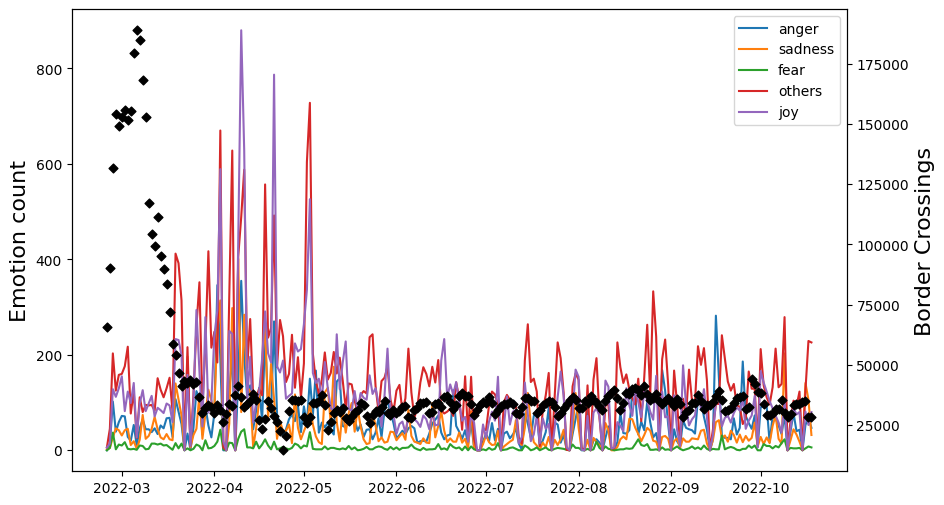

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
for r in all_emotions:
    ax.plot(merged_df.xs(r,level=1).loc[:,'tweet'], label = r)
ax2.scatter(flow_df.index.values, flow_df.border_crossings.values, color='black', marker='D', s=20)
ax.set_ylabel('Emotion count', fontsize=16)
ax2.set_ylabel('Border Crossings', fontsize=16)
ax.legend()

In [ ]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in all_emotions:
            shift = merged_df.xs(e,level=1).loc[:,'tweet'].shift(i)
            print(shift)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr**2)

date
2022-02-24    44.0
2022-02-25    38.0
2022-02-26    46.0
2022-02-27    34.0
2022-02-28    52.0
              ... 
2022-10-14     NaN
2022-10-15     NaN
2022-10-16     NaN
2022-10-17     NaN
2022-10-18     NaN
Freq: D, Name: tweet, Length: 237, dtype: float64
date
2022-02-24    30.0
2022-02-25    45.0
2022-02-26    70.0
2022-02-27    44.0
2022-02-28    27.0
              ... 
2022-10-14     NaN
2022-10-15     NaN
2022-10-16     NaN
2022-10-17     NaN
2022-10-18     NaN
Freq: D, Name: tweet, Length: 237, dtype: float64
date
2022-02-24     3.0
2022-02-25    14.0
2022-02-26    14.0
2022-02-27    12.0
2022-02-28    14.0
              ... 
2022-10-14     NaN
2022-10-15     NaN
2022-10-16     NaN
2022-10-17     NaN
2022-10-18     NaN
Freq: D, Name: tweet, Length: 237, dtype: float64
date
2022-02-24     94.0
2022-02-25     95.0
2022-02-26     83.0
2022-02-27    151.0
2022-02-28    127.0
              ...  
2022-10-14      NaN
2022-10-15      NaN
2022-10-16      NaN
2022-10-17      NaN
202

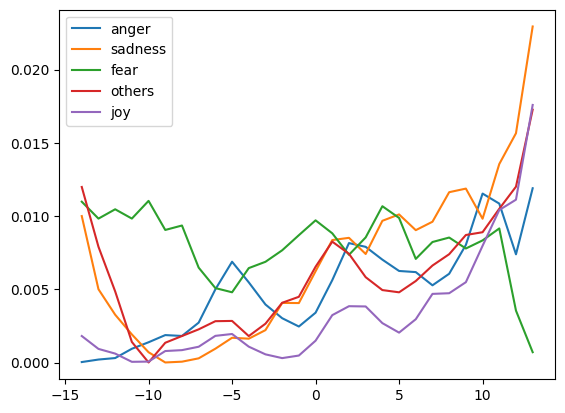

In [ ]:
#graph all correlations from -2 weeks to +2 weeks -- highest two weeks out
fig = plt.figure()
for i in all_emotions:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.legend()
plt.show()


In [ ]:
offset_range = np.arange(0, 30)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in all_emotions:
            shift = merged_df.xs(e,level=1).loc[:,'tweet'].shift(i)
            print(shift)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr**2)

date
2022-02-24      0
2022-02-25     14
2022-02-26    102
2022-02-27     39
2022-02-28     59
             ... 
2022-10-14     43
2022-10-15      0
2022-10-16     53
2022-10-17     69
2022-10-18     47
Freq: D, Name: tweet, Length: 237, dtype: int64
date
2022-02-24      1
2022-02-25      5
2022-02-26     27
2022-02-27     46
2022-02-28     42
             ... 
2022-10-14     18
2022-10-15      1
2022-10-16    141
2022-10-17    106
2022-10-18     32
Freq: D, Name: tweet, Length: 237, dtype: int64
date
2022-02-24     0
2022-02-25     5
2022-02-26    37
2022-02-27     2
2022-02-28    12
              ..
2022-10-14     5
2022-10-15     0
2022-10-16     4
2022-10-17     8
2022-10-18     6
Freq: D, Name: tweet, Length: 237, dtype: int64
date
2022-02-24      6
2022-02-25     45
2022-02-26    203
2022-02-27    125
2022-02-28    158
             ... 
2022-10-14    123
2022-10-15      0
2022-10-16    126
2022-10-17    229
2022-10-18    226
Freq: D, Name: tweet, Length: 237, dtype: int64
date
20

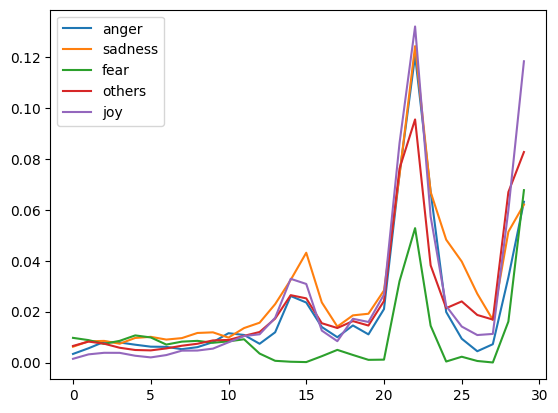

In [ ]:
#graph all correlations to one month shift
fig = plt.figure()
for i in all_emotions:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.legend()
plt.show()

In [ ]:
#Let's look at this 22 day lag -- need to multiply by how many emotions there are (6)
for e in all_emotions:
    shift_df = merged_df.shift(22*5)
shift_df.dropna(inplace=True)
shift_df.head()

tweet
date       emotion       
2022-03-18 anger      0.0
           sadness    1.0
           fear       0.0
           others     6.0
           joy        6.0

            border_crossings
date                        
2022-03-18             58673
2022-03-18             58673
2022-03-18             58673
2022-03-18             58673
2022-03-18             58673


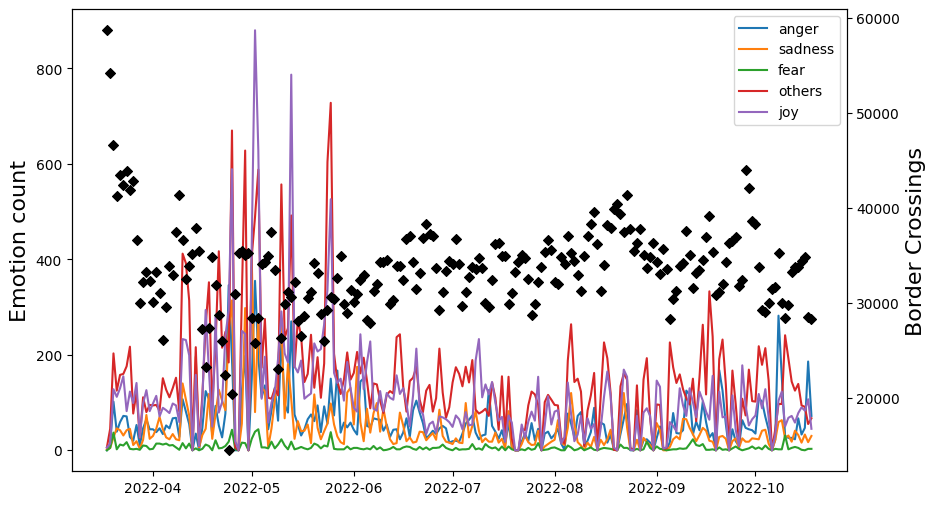

In [ ]:
merged_shift= flow_df.loc[shift_df.index.get_level_values(0)]
print(merged_shift.head())
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
for r in all_emotions:
    ax.plot(shift_df.xs(r,level=1).loc[:,'tweet'], label = r)
ax2.scatter(merged_shift.index.values, merged_shift.border_crossings.values, color='black', marker='D', s=20)
ax.set_ylabel('Emotion count', fontsize=16)
ax2.set_ylabel('Border Crossings', fontsize=16)
ax.legend()